# Part 0: Data Preparation

In [2]:
# !pip install datasets
# !pip install nltk
# !pip install datasets
# !pip install sentencepiece
# !pip install fasttext
# !pip install fuzzywuzzy
# !pip install jellyfish
# !pip install --upgrade pyspellchecker
# !pip install spacy
# !pip install Metaphone
# !pip install symspellpy

In [3]:
# !pip install fuzzy

In [4]:
from datasets import load_dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Part 1: Preparing Word Embeddings

As the first step of building your model, you need to prepare the word embeddings to form the input layer of your model. You are required to choose only from **Word2vec** or **Glove** to initialize your word embedding matrix. The word embedding matrix stores the pre-trained word vectors (taken from Word2vec or Glove) where each row corresponds to a vector for a specific word in the vocabulary formed from your task dataset.set.

In [5]:
import gensim.downloader
import matplotlib.pyplot as plt
import nltk
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from gensim.models import KeyedVectors
import gensim.downloader as api
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JamesYS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Question 1. Word Embedding

### (a) What is the size of the vocabulary formed from your training data?

In [6]:
tokens = []
tokenized_sentences = [nltk.tokenize.word_tokenize(sentence['text'].lower()) for sentence in train_dataset]

for sentence in train_dataset:
    tokens.extend(nltk.tokenize.word_tokenize(sentence['text'].lower()))

print ('Number of tokens: '+ str(len(tokens)))

Number of tokens: 183968


In [7]:
glove_file = './glove.840B.300d/glove.840B.300d.txt'  # adjust path and file name accordingly

# Convert the GloVe format to Gensim's Word2Vec format
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

# Print the embedding dimension to verify
embedding_dim = glove_model.vector_size
print("Embedding dimension:", embedding_dim)

Embedding dimension: 300


In [8]:
# List of all distinct words found in the tokens list
vocab = list(set(tokens))
vocab_size = len(vocab)
print ('Number of token types (Vocabulary Size): '+ str(vocab_size))

Number of token types (Vocabulary Size): 18029


(a) The size of vocabulary formed from the training data is 18029.

### (b) We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but  not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?

In [9]:
# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
oov_words = []

# Map vocabulary to embedding matrix
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

for word, idx in word_to_idx.items():
    if word in glove_model:
        embedding_matrix[idx] = glove_model[word]
    else:
        # Count OOV words
        oov_words.append(word)

# OOV words count
oov_count = len(oov_words)
print("Number of OOV words:", oov_count)

Number of OOV words: 1387


(b) There are **3612** OOV words in the training data.   

### (c) The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove). Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you think is the best strategy to mitigate such limitation? Implement your solution in your source code. Show the corresponding code snippet.

#### Method: Back-off


1. Word Preprocessing: Split compound words with dashes/hyphens (e.g., "super-man" to "super" and "man") and remove punctuation.
2. Spelling Correction (SymSpell): Apply the Symmetric Delete Spelling Correction algorithm for fast, efficient spelling corrections.
3. Direct Glove Lookup: Check each preprocessed and corrected token in Glove, returning the longest match for maximum semantic relevance.
4. Byte Pair Encoding (BPE): For tokens not found in Glove, break them into subwords using Byte Pair Encoding.
5. Subword Lookup in Glove: Check each BPE subword in Glove, returning the longest valid subword if found.
6. Stopword Handling: Skip processing stopwords entirely, returning None for them as they generally lack semantic value.

(c) Explanation
Word Preprocessing: This initial step simplifies complex tokens by removing unnecessary punctuation and splitting compound words. By handling these irregularities early, the algorithm can better match tokens with the Glove vocabulary. This preprocessing also reduces complexity in later stages by standardizing tokens, which improves the accuracy and efficiency of matching.

SymSpell for Spelling Correction: SymSpell is a highly efficient spelling correction algorithm based on the symmetric delete approach. Unlike traditional spell checkers, which generate all possible edit variations, SymSpell only generates deletions, making it computationally faster. SymSpell’s design ensures that even when dealing with a large dictionary or a high edit distance, the lookup time remains minimal. This efficiency is crucial when handling large text corpora or applications requiring real-time processing.

Direct Glove Lookup: After preprocessing and spelling correction, each token is checked directly against Glove, a computationally lightweight, vector-based word embedding model. Unlike models like BERT or Transformers that involve heavy attention mechanisms and complex architectures, Glove relies on efficient vector comparisons for word lookup. By prioritizing the longest matching word in Glove, the method retains more semantic content with minimal computation.

Byte Pair Encoding (BPE): BPE breaks down unknown tokens into subword units, making it effective for handling out-of-vocabulary (OOV) tokens. Unlike Transformer-based models, where subwords are used within an attention-based structure, BPE here functions solely as a fallback strategy to approximate word meanings without heavy computation. This avoids the high memory and processing requirements of transformers by focusing only on efficient token decomposition.

Subword Lookup: After BPE segmentation, each subword is checked in Glove, with the algorithm selecting the longest valid subword available. By checking for subword matches in Glove, the method preserves as much meaning as possible while avoiding the extensive computational overhead associated with Transformers’ multi-layered attention calculations. This ensures a balance between coverage and efficiency, making it suitable for large-scale or real-time applications.

Stopword Handling: Stopwords are excluded from processing because they contribute little semantic value. This decision not only saves processing time but also reduces the load on memory and lookup functions. By avoiding unnecessary operations on stopwords, the method further optimizes performance.

Why This Approach is Efficient
This backoff method is designed with efficiency in mind, leveraging lightweight preprocessing steps, SymSpell, Glove, and BPE, which all require significantly less computational power than Transformer models like BERT. Transformer-based models rely on multi-layered self-attention mechanisms to capture relationships between words, which is computationally expensive. Each layer in a Transformer processes tokens with high-dimensional matrices, requiring substantial GPU/TPU power and memory.

In contrast, this approach does not involve any attention mechanisms or heavy matrix operations. Glove embeddings allow for quick, straightforward vector comparisons, and SymSpell’s delete-only approach drastically reduces the number of candidates to process for spelling corrections. Furthermore, using BPE solely as a token decomposition method (without embedding these subwords in a Transformer context) further reduces computational load.

This efficient design makes it suitable for applications where speed and lower resource consumption are crucial, such as real-time text processing, mobile applications, or low-resource environments.

In [10]:
# Define a function to find replacement words based on cosine similarity
# def find_replacement_word(oov_word, model, topn=5):
#     subword_vectors = [model[word] for word in oov_word if word in model]

#     if subword_vectors:  # If there are subwords with embeddings
#         # Generate vector for OOV by averaging embeddings of subwords
#         oov_vector = np.mean(subword_vectors, axis=0)

#         # Find similar words to this estimated vector
#         similar_words = model.similar_by_vector(oov_vector, topn=topn)

#         # Return the word with highest similarity
#         return similar_words[0][0] if similar_words else None

#     return None

In [11]:
# Load the dataset
train_texts = dataset['train']['text']

# Save the train texts to a file
with open("train_texts.txt", "w", encoding="utf-8") as f:
    for line in train_texts:
        f.write(line + "\n")

In [12]:
import sentencepiece as spm

# Train SentencePiece model
spm.SentencePieceTrainer.train(
    input="train_texts.txt",
    model_prefix="bpe_model",
    vocab_size= 18029,  # Choose an appropriate size for your dataset
    model_type="bpe"  # Specify BPE model
)


In [13]:
sp = spm.SentencePieceProcessor(model_file="bpe_model.model")

# Example usage
encoded_text = sp.encode("badly-rendered", out_type=str)
print(encoded_text)  # Output will be a list of subword tokens

['▁badly', '-', 'rendered']


In [14]:
from nltk.corpus import stopwords

nltk.download('stopwords')

# Load English stopwords from nltk
stopword_set = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JamesYS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stopword_set

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [16]:
import requests

# URLs for the pre-built dictionaries from the SymSpell GitHub repository
frequency_dict_url = "https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt"
bigram_dict_url = "https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_bigramdictionary_en_243_342.txt"

# File names for saving the dictionaries
frequency_dict_filename = "frequency_dictionary_en_82_765.txt"
bigram_dict_filename = "frequency_bigramdictionary_en_243_342.txt"

# Function to download a file from a URL
def download_file(url, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {filename}")

# Download the frequency dictionary
download_file(frequency_dict_url, frequency_dict_filename)

# Download the bigram dictionary
download_file(bigram_dict_url, bigram_dict_filename)


Downloaded frequency_dictionary_en_82_765.txt
Downloaded frequency_bigramdictionary_en_243_342.txt


In [17]:
from symspellpy.symspellpy import SymSpell, Verbosity

# Initialize SymSpell
max_edit_distance = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance, prefix_length)

# Load the dictionaries from the local file path
frequency_dictionary_path = "frequency_dictionary_en_82_765.txt"
bigram_dictionary_path = "frequency_bigramdictionary_en_243_342.txt"

# Load the frequency dictionary
sym_spell.load_dictionary(frequency_dictionary_path, term_index=0, count_index=1)

# Optionally load the bigram dictionary for improved correction suggestions
sym_spell.load_bigram_dictionary(bigram_dictionary_path, term_index=0, count_index=2)

True

In [18]:
from symspellpy import SymSpell, Verbosity

# Initialize SymSpell with maximum edit distance and prefix length
def initialize_symspell(max_edit_distance=2, prefix_length=7):
    sym_spell = SymSpell(max_edit_distance, prefix_length)
    # Load the frequency dictionary
    frequency_dict_path = "frequency_dictionary_en_82_765.txt"
    sym_spell.load_dictionary(frequency_dict_path, term_index=0, count_index=1)
    return sym_spell

# Function to get the best correction
def get_best_correction(word, sym_spell):
    # Get the highest-frequency suggestion for the word
    suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
    # Return the term with the highest frequency if suggestions are found
    if suggestions:
        return suggestions[0].term
    else:
        return word  # Return the original word if no suggestions are found

# Example usage:
# Initialize SymSpell (do this only once at the start of your program)
sym_spell = initialize_symspell()

# Get the best correction for a misspelled word
misspelled_word = "diferença"
best_correction = get_best_correction(misspelled_word, sym_spell)
print(f"Best correction for '{misspelled_word}': {best_correction}")


Best correction for 'diferença': diferença


In [19]:
import numpy as np
import sentencepiece as spm
from nltk.stem import PorterStemmer
#from spellchecker import SpellChecker
import jellyfish
import re

# Initialize SpellChecker
#spell_checker = SpellChecker()

def preprocess_token(token):
    # Replace separators like '-' or '/' with whitespace
    token = re.sub(r"[-/]", " ", token)
    # Remove underscores and all other punctuation
    token = re.sub(r"[^\w\s]", "", token)
    print(f"Preprocessed token: {token}")
    return token

def find_best_valid_subword(subwords, model):
    longest_valid_subword = None
    for subword in subwords:
        if subword in model and (longest_valid_subword is None or len(subword) > len(longest_valid_subword)):
            longest_valid_subword = subword
    print(f"Best valid subword found: {longest_valid_subword}")
    return longest_valid_subword

def find_longest_match_in_model(tokens, model):
    # Check each token against the model and return the longest valid match
    longest_match = None
    for token in tokens:
        if token in model and (longest_match is None or len(token) > len(longest_match)):
            longest_match = token
    print(f"Longest match in model: {longest_match}")
    return longest_match


def find_replacement_word(token, model, sp,sym_spell):
    print(f"\nProcessing token: '{token}'")

    if token.lower() in stopword_set:
        print(f"'{token}' is a stopword; skipping replacement.")
        return None

    # Preprocess token to handle punctuation and separators
    cleaned_token = preprocess_token(token)
    # Split cleaned token into individual words if it's a multi-token string
    individual_tokens = cleaned_token.split()
    individual_tokens = [
    get_best_correction(word, sym_spell) if get_best_correction(word, sym_spell) else word for word in individual_tokens]

    print(f"Individual tokens: {individual_tokens}")

    # 1. Direct model check for each individual token
    longest_match = find_longest_match_in_model(individual_tokens, model)
    if longest_match:
        return longest_match

    # 2. Stem each token and check in the model
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(t) for t in individual_tokens]
    print(f"Stemmed tokens: {stemmed_tokens}")

    longest_match = find_longest_match_in_model(stemmed_tokens, model)
    if longest_match:
        return longest_match

    # 3. Encode each individual token to get subwords and check for the best valid subword
    subwords = []
    for t in individual_tokens:
        try:
            token_subwords = sp.encode(t, out_type=str)
            print(f"Subwords for '{t}': {token_subwords}")
            subwords.extend(token_subwords)
        except Exception as e:
            print(f"Error in encoding subwords for '{t}': {e}")

    # Find the best valid subword in the model
    longest_subword = find_best_valid_subword(subwords, model)
    if longest_subword:
        return longest_subword
    print("No valid replacement found.")
    return None


# Initialize SentencePiece model
sp = spm.SentencePieceProcessor(model_file="bpe_model.model")


In [20]:
# Sample token to find replacement for
token = "leopar"
#the stem words shou
# Use the function to find a replacement
replacement = find_replacement_word(token, glove_model, sp,sym_spell)
print("Replacement word:", replacement)


Processing token: 'leopar'
Preprocessed token: leopar
Individual tokens: ['leopard']
Longest match in model: leopard
Replacement word: leopard


In [21]:
# Sample token stopword
token = "a"
#the stem words shou
# Use the function to find a replacement
replacement = find_replacement_word(token, glove_model, sp,sym_spell)
print("Replacement word:", replacement)


Processing token: 'a'
'a' is a stopword; skipping replacement.
Replacement word: None


# Part 2: Model Training & Evaluation - RNN

Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from Part 0, you need to train a deep learning model for sentiment classification using the training set, conforming to these requirements:
- Use the pretrained word embeddings from Part 1 as inputs; do not update them during training (they are “frozen”).
- Design a simple recurrent neural network (RNN), taking the input word embeddings, and predicting a sentiment label for each sentence. To do that, you need to consider how to aggregate the word representations to represent a sentence.
- Use the validation set to gauge the performance of the model for each epoch during training. You are required to use **accuracy** as the performance metric during validation and evaluation.
- Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g., SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and mini-batch size. (You should use the validation set to determine the optimal configuration.) Train the model until the **accuracy** score on the validation set is not increasing for a few epochs.
- Evaluate your trained model on the test dataset, observing the **accuracy** score.

## Question 2: RNN

### (a) Report the final configuration of your best model, namely the number of training epochs, learning rate, optimizer, batch size.

### (b) Report the **accuracy** score on the test set, as well as the accuracy score on the validation  set for each epoch during training.

### (c) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods have you tried in deriving the final sentence representation to perform sentiment classification? Describe all the strategies you have implemented, together with their accuracy scores on the test set.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence

In [23]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")
# device = 'cpu'

In [24]:
# Initialize an empty dictionary to store test accuracies
test_accuracies = {}

In [25]:
max_length = max(len(item) for item in tokens)

In [26]:
def prepare_data(dataset, word_to_idx, max_len):
    sequences = []
    labels = []

    for sentence in dataset:
        tokenized = nltk.tokenize.word_tokenize(sentence['text'].lower())
        indices = [word_to_idx[word] for word in tokenized if word in word_to_idx]
        sequences.append(torch.tensor(indices[:max_len]))  # Trim to max_len
        labels.append(sentence['label'])

    # Pad sequences to ensure all are the same length
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    # Convert labels to tensor
    labels = torch.tensor(labels)

    return padded_sequences, labels

(c) For deriving sentence representations, we implemented different strategies:
- **Last Hidden State**: Use the last hidden state of the RNN.
- **Max Pooling**: Take the maximum hidden state across all words.
- **Average Pooling**: Average the hidden states across all words.

In [27]:
class LastHiddenRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(LastHiddenRNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.rnn(embedded)
        # Aggregate using the last hidden state
        last_hidden = hidden[-1]
        output = self.fc(last_hidden)
        return output

class MaxPoolingRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(MaxPoolingRNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.rnn(embedded)
        # Max pooling over all hidden states
        max_pooled, _ = torch.max(rnn_output, dim=1)
        output = self.fc(max_pooled)
        return output

class AveragePoolingRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(AveragePoolingRNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, _ = self.rnn(embedded)

        # Average pooling over the hidden states
        mean_pooled = rnn_output.mean(dim=1)  # Take the mean across the sequence length dimension
        output = self.fc(mean_pooled)  # Pass through the fully connected layer
        return output

In [28]:
# Training function
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()  # Set model to training mode
    train_loss = 0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Accumulate loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average accuracy and loss
    train_acc = train_correct / total_train
    train_loss /= len(train_loader)  # Average loss per batch

    return train_loss, train_acc

# Validation function
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total  # Return validation accuracy

# Training loop with validation
def train_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience=3):
    best_val_acc = 0
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    model = model.to(device)

    for epoch in range(epochs):
        # Training step
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation step
        val_acc = evaluate_model(model, validation_loader)
        val_accuracies.append(val_acc)

        # Print training and validation results
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model = model.state_dict()  # Save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    model.load_state_dict(best_model)  # Load the best model weights

    return model, train_losses, train_accuracies, val_accuracies

In [29]:
# Define hyperparameter search space
learning_rates = [0.001, 0.005, 0.01, 0.1]
batch_sizes = [16, 32, 64]
optimizers = ['SGD', 'Adam', 'RMSprop','Adagrad']

In [30]:
def train_and_evaluate_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience):
    # Training the model (uses functions defined earlier for training and evaluation)
    model, train_losses, train_accuracies, val_accuracies = train_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience)

    # Get best validation accuracy
    best_val_acc = max(val_accuracies)

    return best_val_acc, train_losses, train_accuracies, val_accuracies

In [31]:
def run_grid_search(model_class, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                    validation_sequences, validation_labels, criterion, epochs, patience):

    best_val_acc = 0
    best_hyperparams = {}

    # Prepare datasets
    train_data = TensorDataset(train_sequences.to(device), train_labels.to(device))
    validation_data = TensorDataset(validation_sequences.to(device), validation_labels.to(device))

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for opt in optimizers:
                print(f"Training with lr={lr}, batch_size={batch_size}, optimizer={opt}")

                # Set up DataLoader with the current batch size
                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

                # Initialize a new model for each set of hyperparameters
                model = model_class(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim)  # Reinitialize model
                model = model.to(device)

                # Choose optimizer
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif opt == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=lr)
                elif opt == 'Adagrad':
                    optimizer = optim.Adagrad(model.parameters(), lr=lr)

                # Train and evaluate the model
                val_acc, _, _, _ = train_and_evaluate_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience)


                # Track the best configuration based on validation accuracy
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'optimizer': opt}

    print(f"Best Validation Accuracy: {best_val_acc}")
    print(f"Best Hyperparameters: {best_hyperparams}")

    return best_hyperparams

In [32]:
# Prepare the train, validation, and test datasets
train_sequences, train_labels = prepare_data(train_dataset, word_to_idx, max_length)
validation_sequences, validation_labels = prepare_data(validation_dataset, word_to_idx, max_length)
test_sequences, test_labels = prepare_data(test_dataset, word_to_idx, max_length)

In [33]:
train_sequences = train_sequences.to(device)
train_labels = train_labels.to(device)
validation_sequences = validation_sequences.to(device)
validation_labels = validation_labels.to(device)
test_sequences = test_sequences.to(device)
test_labels = test_labels.to(device)

In [34]:
# Plot accuracy scores
def plot_metrics(epochs, train_losses, train_accuracies, val_accuracies):
    # Epochs range
    epoch_range = range(1, epochs + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, train_accuracies, label='Train Accuracy')
    plt.plot(epoch_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()

In [35]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

### 1) RNN Last Hidden State

In [36]:
# Call grid search
best_hyperparams_RNN_last = run_grid_search(LastHiddenRNNModel, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                            validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6939, Train Acc: 0.4968, Val Acc: 0.5150
Epoch 2, Train Loss: 0.6934, Train Acc: 0.4996, Val Acc: 0.5131
Epoch 3, Train Loss: 0.6938, Train Acc: 0.4988, Val Acc: 0.5122
Epoch 4, Train Loss: 0.6934, Train Acc: 0.4917, Val Acc: 0.5113
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.7003, Train Acc: 0.4995, Val Acc: 0.4953
Epoch 2, Train Loss: 0.7180, Train Acc: 0.4988, Val Acc: 0.4841
Epoch 3, Train Loss: 0.7070, Train Acc: 0.5120, Val Acc: 0.5019
Epoch 4, Train Loss: 0.7032, Train Acc: 0.5096, Val Acc: 0.5038
Epoch 5, Train Loss: 0.7011, Train Acc: 0.5158, Val Acc: 0.5159
Epoch 6, Train Loss: 0.7032, Train Acc: 0.5050, Val Acc: 0.4962
Epoch 7, Train Loss: 0.7099, Train Acc: 0.5072, Val Acc: 0.5047
Epoch 8, Train Loss: 0.7077, Train Acc: 0.5025, Val Acc: 0.4878
Early stopping
Training with lr=0.001, batch_size=16, optimizer=RMSprop
Epoch 1, Train Loss: 0.7182, Train Acc

In [37]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_last['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [38]:
# Retrain using best hyperparameters
best_model_RNN_last = LastHiddenRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_last['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])
elif best_hyperparams_RNN_last['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])
elif best_hyperparams_RNN_last['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])
elif best_hyperparams_RNN_last['optimizer']=='Adagrad':
    best_optimizer = optim.Adagrad(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])

best_model_RNN_last, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_last, train_loader, validation_loader,
                                                                                  best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.6942, Train Acc: 0.5063, Val Acc: 0.5131
Epoch 2, Train Loss: 0.6918, Train Acc: 0.5016, Val Acc: 0.4953
Epoch 3, Train Loss: 0.6905, Train Acc: 0.5121, Val Acc: 0.5150
Epoch 4, Train Loss: 0.5933, Train Acc: 0.6887, Val Acc: 0.7129
Epoch 5, Train Loss: 0.5278, Train Acc: 0.7475, Val Acc: 0.7627
Epoch 6, Train Loss: 0.5066, Train Acc: 0.7625, Val Acc: 0.7064
Epoch 7, Train Loss: 0.5045, Train Acc: 0.7617, Val Acc: 0.7702
Epoch 8, Train Loss: 0.4972, Train Acc: 0.7649, Val Acc: 0.7627
Epoch 9, Train Loss: 0.4965, Train Acc: 0.7639, Val Acc: 0.7720
Epoch 10, Train Loss: 0.4905, Train Acc: 0.7683, Val Acc: 0.7824
Epoch 11, Train Loss: 0.4936, Train Acc: 0.7661, Val Acc: 0.7692
Epoch 12, Train Loss: 0.4890, Train Acc: 0.7644, Val Acc: 0.7674
Epoch 13, Train Loss: 0.4868, Train Acc: 0.7714, Val Acc: 0.7664
Early stopping


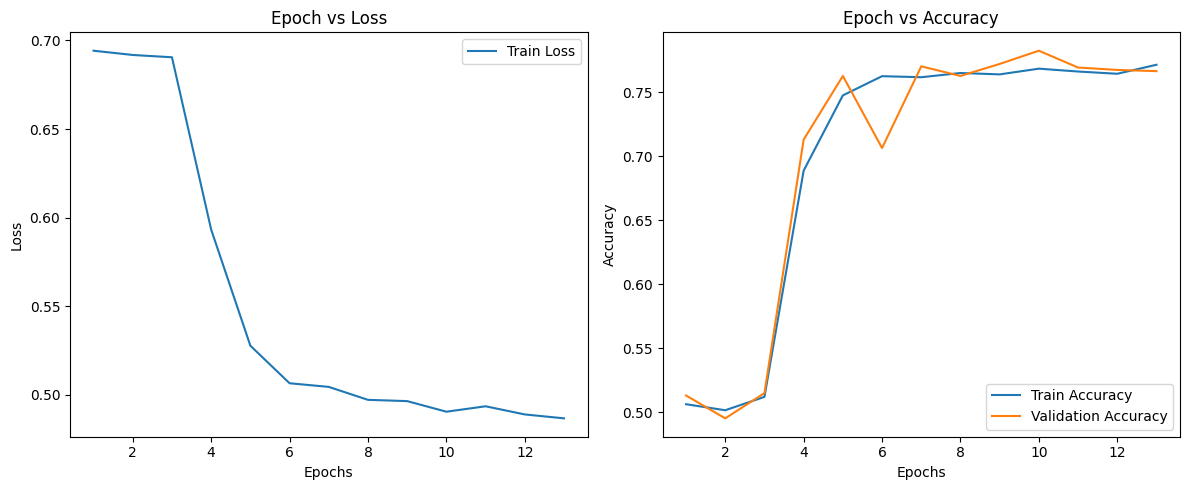

In [39]:
epochs_LHS = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_LHS, train_losses, train_accuracies, val_accuracies)

In [40]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_last, test_loader)
test_accuracies['RNN Last Hidden State'] = test_acc
print(f'Test Accuracy (RNN Last Hidden State): {test_acc:.4f}')

Test Accuracy (RNN Last Hidden State): 0.7692


### 2) RNN Max Pooling

In [41]:
# Call grid search
best_hyperparams_RNN_max = run_grid_search(MaxPoolingRNNModel, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                           validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6948, Train Acc: 0.4961, Val Acc: 0.5009
Epoch 2, Train Loss: 0.6897, Train Acc: 0.5359, Val Acc: 0.5600
Epoch 3, Train Loss: 0.6857, Train Acc: 0.5651, Val Acc: 0.5103
Epoch 4, Train Loss: 0.6821, Train Acc: 0.5804, Val Acc: 0.6388
Epoch 5, Train Loss: 0.6764, Train Acc: 0.6208, Val Acc: 0.6557
Epoch 6, Train Loss: 0.6720, Train Acc: 0.6297, Val Acc: 0.6276
Epoch 7, Train Loss: 0.6652, Train Acc: 0.6530, Val Acc: 0.6191
Epoch 8, Train Loss: 0.6594, Train Acc: 0.6619, Val Acc: 0.6698
Epoch 9, Train Loss: 0.6510, Train Acc: 0.6815, Val Acc: 0.7008
Epoch 10, Train Loss: 0.6417, Train Acc: 0.6943, Val Acc: 0.6989
Epoch 11, Train Loss: 0.6303, Train Acc: 0.6984, Val Acc: 0.7120
Epoch 12, Train Loss: 0.6163, Train Acc: 0.7067, Val Acc: 0.7083
Epoch 13, Train Loss: 0.5958, Train Acc: 0.7202, Val Acc: 0.7111
Epoch 14, Train Loss: 0.5683, Train Acc: 0.7263, Val Acc: 0.7148
Epoch 15, Train Loss: 0.5482, Train Acc: 0.724

In [42]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_max['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [43]:
# Retrain using best hyperparameters
best_model_RNN_max = MaxPoolingRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_max['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])
elif best_hyperparams_RNN_max['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])
elif best_hyperparams_RNN_max['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])
elif best_hyperparams_RNN_max['optimizer']=='Adagrad':
    best_optimizer = optim.Adagrad(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])

best_model_RNN_max, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_max, train_loader, validation_loader,
                                                                                 best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5287, Train Acc: 0.7290, Val Acc: 0.7767
Epoch 2, Train Loss: 0.4624, Train Acc: 0.7755, Val Acc: 0.7580
Epoch 3, Train Loss: 0.4437, Train Acc: 0.7899, Val Acc: 0.7683
Epoch 4, Train Loss: 0.4234, Train Acc: 0.7973, Val Acc: 0.7974
Epoch 5, Train Loss: 0.4138, Train Acc: 0.8047, Val Acc: 0.7739
Epoch 6, Train Loss: 0.3925, Train Acc: 0.8212, Val Acc: 0.7842
Epoch 7, Train Loss: 0.3895, Train Acc: 0.8188, Val Acc: 0.7786
Early stopping


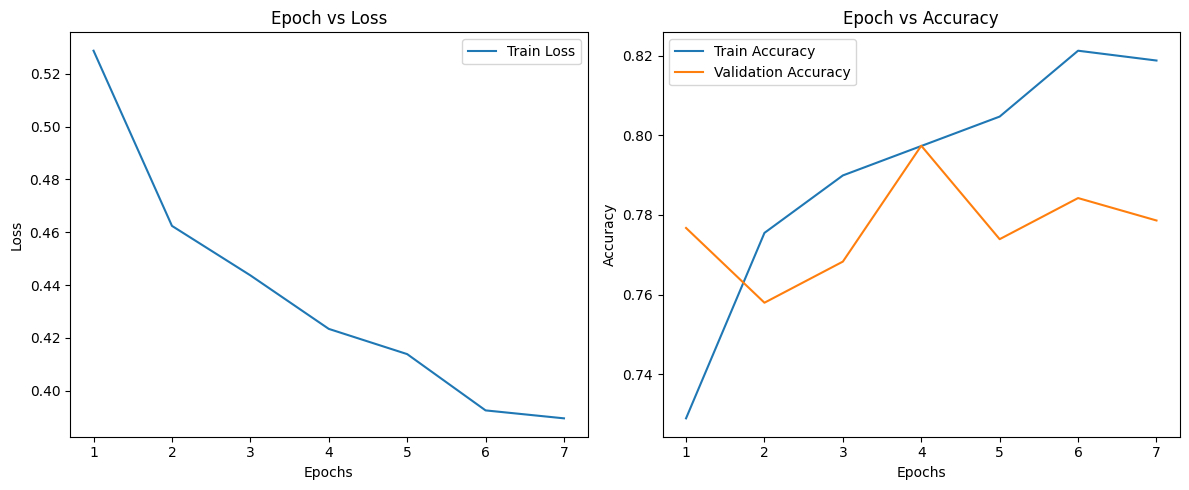

In [44]:
epochs_max = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_max, train_losses, train_accuracies, val_accuracies)

In [45]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_max, test_loader)
test_accuracies['RNN Max Pooling'] = test_acc
print(f'Test Accuracy (RNN Max Pooling): {test_acc:.4f}')

Test Accuracy (RNN Max Pooling): 0.7871


### 3) RNN Average Pooling

In [46]:
# Call grid search
best_hyperparams_RNN_avg = run_grid_search(AveragePoolingRNNModel, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                   validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6916, Train Acc: 0.5450, Val Acc: 0.5854
Epoch 2, Train Loss: 0.6904, Train Acc: 0.5879, Val Acc: 0.6173
Epoch 3, Train Loss: 0.6896, Train Acc: 0.6045, Val Acc: 0.6473
Epoch 4, Train Loss: 0.6884, Train Acc: 0.6260, Val Acc: 0.6510
Epoch 5, Train Loss: 0.6872, Train Acc: 0.6366, Val Acc: 0.6745
Epoch 6, Train Loss: 0.6863, Train Acc: 0.6478, Val Acc: 0.6745
Epoch 7, Train Loss: 0.6848, Train Acc: 0.6608, Val Acc: 0.6857
Epoch 8, Train Loss: 0.6836, Train Acc: 0.6703, Val Acc: 0.6811
Epoch 9, Train Loss: 0.6820, Train Acc: 0.6696, Val Acc: 0.6895
Epoch 10, Train Loss: 0.6808, Train Acc: 0.6733, Val Acc: 0.6857
Epoch 11, Train Loss: 0.6791, Train Acc: 0.6783, Val Acc: 0.6820
Epoch 12, Train Loss: 0.6773, Train Acc: 0.6785, Val Acc: 0.6867
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.5694, Train Acc: 0.7161, Val Acc: 0.6904
Epoch 2, Train Loss: 0.5299, Train Acc: 0.7

In [47]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_avg['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [48]:
# Retrain using best hyperparameters
best_model_RNN_avg = AveragePoolingRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_avg['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])
elif best_hyperparams_RNN_avg['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])
elif best_hyperparams_RNN_avg['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])
elif best_hyperparams_RNN_avg['optimizer']=='Adagrad':
    best_optimizer = optim.Adagrad(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])
best_model_RNN_avg, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_avg, train_loader, validation_loader,
                                                                                 best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5946, Train Acc: 0.6870, Val Acc: 0.7486
Epoch 2, Train Loss: 0.5146, Train Acc: 0.7515, Val Acc: 0.7411
Epoch 3, Train Loss: 0.4985, Train Acc: 0.7578, Val Acc: 0.7439
Epoch 4, Train Loss: 0.4932, Train Acc: 0.7623, Val Acc: 0.7617
Epoch 5, Train Loss: 0.4845, Train Acc: 0.7666, Val Acc: 0.7664
Epoch 6, Train Loss: 0.4778, Train Acc: 0.7676, Val Acc: 0.7411
Epoch 7, Train Loss: 0.4713, Train Acc: 0.7701, Val Acc: 0.7645
Epoch 8, Train Loss: 0.4703, Train Acc: 0.7744, Val Acc: 0.7720
Epoch 9, Train Loss: 0.4697, Train Acc: 0.7712, Val Acc: 0.7749
Epoch 10, Train Loss: 0.4593, Train Acc: 0.7766, Val Acc: 0.7627
Epoch 11, Train Loss: 0.4635, Train Acc: 0.7727, Val Acc: 0.7871
Epoch 12, Train Loss: 0.4576, Train Acc: 0.7773, Val Acc: 0.7767
Epoch 13, Train Loss: 0.4577, Train Acc: 0.7812, Val Acc: 0.7683
Epoch 14, Train Loss: 0.4530, Train Acc: 0.7808, Val Acc: 0.7720
Early stopping


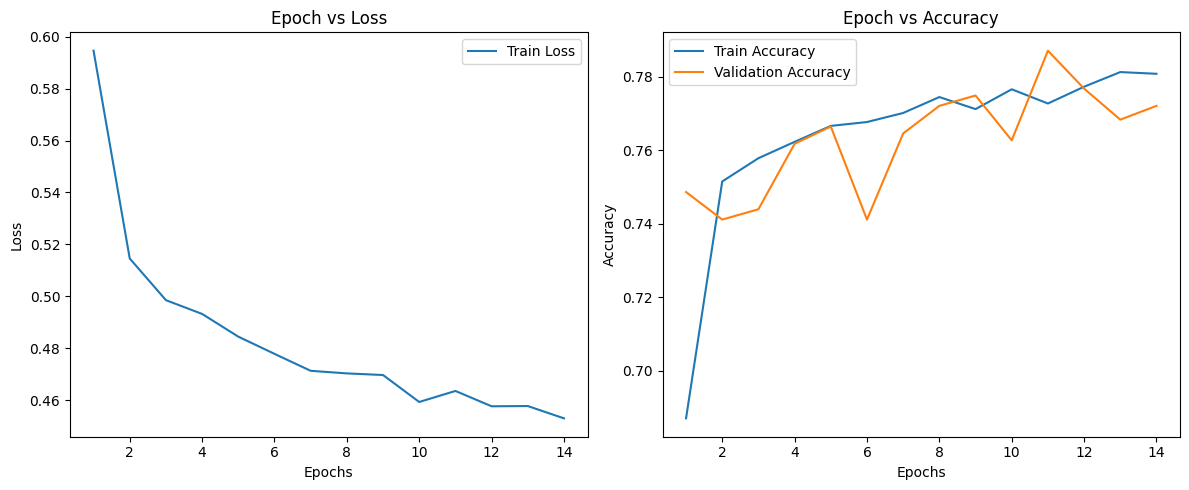

In [49]:
epochs_avg = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_avg, train_losses, train_accuracies, val_accuracies)

In [50]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_avg, test_loader)
test_accuracies['RNN Average Pooling'] = test_acc
print(f'Test Accuracy (RNN Average Pooling): {test_acc:.4f}')

Test Accuracy (RNN Average Pooling): 0.7730


In [51]:
test_accuracies

{'RNN Last Hidden State': 0.7692307692307693,
 'RNN Max Pooling': 0.7870544090056285,
 'RNN Average Pooling': 0.7729831144465291}

**Max pooling** achieved the highest test accuracy of 0.7870.    
Thus, in the following sectinos we will apply max pooling to derive the final sentence representation to perform sentiment classification.

# Part 3: Enhancement

The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In  this section, you will design strategies to improve upon the previous model you have built. You ar
 required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards a meaningful improvement.

## Question 3: Enhancement

### (a) Report the accuracy score on the test set when the word embeddings are updated (Part 3.1).

Set `freeze=False` when initializing the embedding layer to allow word embeddings update.

In [52]:
class MaxPoolingRNNModelUpdate(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(MaxPoolingRNNModelUpdate, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.rnn(embedded)
        # Max pooling over all hidden states
        max_pooled, _ = torch.max(rnn_output, dim=1)
        output = self.fc(max_pooled)
        return output

In [53]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

# Call grid search
best_hyperparams_RNN_update = run_grid_search(MaxPoolingRNNModelUpdate, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                   validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6916, Train Acc: 0.5375, Val Acc: 0.5666
Epoch 2, Train Loss: 0.6854, Train Acc: 0.5619, Val Acc: 0.5985
Epoch 3, Train Loss: 0.6805, Train Acc: 0.5966, Val Acc: 0.6069
Epoch 4, Train Loss: 0.6761, Train Acc: 0.6123, Val Acc: 0.6529
Epoch 5, Train Loss: 0.6711, Train Acc: 0.6385, Val Acc: 0.6735
Epoch 6, Train Loss: 0.6658, Train Acc: 0.6559, Val Acc: 0.6745
Epoch 7, Train Loss: 0.6584, Train Acc: 0.6722, Val Acc: 0.6961
Epoch 8, Train Loss: 0.6511, Train Acc: 0.6810, Val Acc: 0.6782
Epoch 9, Train Loss: 0.6426, Train Acc: 0.6940, Val Acc: 0.7036
Epoch 10, Train Loss: 0.6324, Train Acc: 0.7038, Val Acc: 0.7054
Epoch 11, Train Loss: 0.6188, Train Acc: 0.7096, Val Acc: 0.6820
Epoch 12, Train Loss: 0.6030, Train Acc: 0.7108, Val Acc: 0.7101
Epoch 13, Train Loss: 0.5830, Train Acc: 0.7149, Val Acc: 0.7111
Epoch 14, Train Loss: 0.5611, Train Acc: 0.7247, Val Acc: 0.7092
Epoch 15, Train Loss: 0.5431, Train Acc: 0.725

In [54]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_update['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [55]:
# Retrain using best hyperparameters
best_model_RNN_update = MaxPoolingRNNModelUpdate(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_update['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])
elif best_hyperparams_RNN_update['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])
elif best_hyperparams_RNN_update['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])
elif best_hyperparams_RNN_update['optimizer']=='Adagrad':
    best_optimizer = optim.Adagrad(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])
best_model_RNN_update, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_update, train_loader, validation_loader,
                                                                                    best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.6235, Train Acc: 0.6543, Val Acc: 0.7439
Epoch 2, Train Loss: 0.4109, Train Acc: 0.8080, Val Acc: 0.7917
Epoch 3, Train Loss: 0.3222, Train Acc: 0.8610, Val Acc: 0.7617
Epoch 4, Train Loss: 0.2503, Train Acc: 0.8984, Val Acc: 0.7946
Epoch 5, Train Loss: 0.1881, Train Acc: 0.9275, Val Acc: 0.7767
Epoch 6, Train Loss: 0.1428, Train Acc: 0.9470, Val Acc: 0.7373
Epoch 7, Train Loss: 0.0994, Train Acc: 0.9644, Val Acc: 0.7833
Early stopping


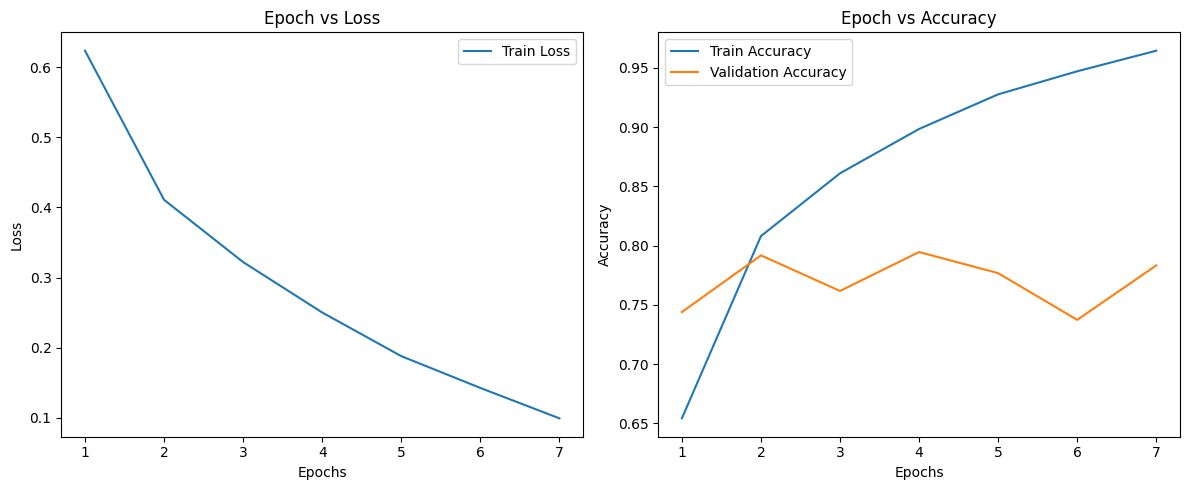

In [56]:
epochs_mp = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_mp, train_losses, train_accuracies, val_accuracies)

In [57]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_update, test_loader)
test_accuracies['RNN (Update Word Embeddings)'] = test_acc
print(f'Test Accuracy (Update Word Embeddings): {test_acc:.4f}')

Test Accuracy (Update Word Embeddings): 0.8133


### (b) Report the accuracy score on the test set when applying your method to deal with OOV words in Part 3.2.

In [58]:
# # Initialize the embedding matrix
# embedding_matrix_spelling_bpe = np.zeros((vocab_size, embedding_dim))

# # Map vocabulary to embedding matrix
# word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# # Populate embedding matrix and handle OOV words
# for word, idx in word_to_idx.items():
#     if word in word2vec_model:
#         embedding_matrix_spelling_bpe[idx] = word2vec_model[word]
#     else:
#         # Handle OOV words
#         replacement_word = find_replacement_word(word, word2vec_model)

#         if replacement_word:
#             embedding_matrix_spelling_bpe[idx] = word2vec_model[replacement_word]  # Use replacement word vector
#         else:
#             embedding_matrix_spelling_bpe[idx] = np.random.normal(size=(embedding_dim,))  # Random initialization if no replacement found

In [59]:
import numpy as np
import logging

# Initialize logging to log the replacement process
logging.basicConfig(filename="oov_handling.log", level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s")

# Initialize the embedding matrix with zeros
embedding_matrix_spelling_bpe = np.zeros((vocab_size, embedding_dim))

# Map vocabulary to indices in the embedding matrix
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Populate embedding matrix and handle OOV words
for word, idx in word_to_idx.items():
    if word in glove_model:
        embedding_matrix_spelling_bpe[idx] = glove_model[word]
    else:
        # Attempt to find a replacement for OOV words
        replacement_word = find_replacement_word(word, glove_model,sp,sym_spell)
        if replacement_word and replacement_word in glove_model:
            embedding_matrix_spelling_bpe[idx] = glove_model[replacement_word]  # Use replacement word vector
            logging.info(f"Replaced OOV word '{word}' with '{replacement_word}' in embedding matrix.")
        else:
            # Initialize with a random vector if no suitable replacement is found
            embedding_matrix_spelling_bpe[idx] = np.random.normal(size=(embedding_dim,))
            logging.info(f"OOV word '{word}' was not replaced; initialized with random vector.")



Processing token: 'belinsky'
Preprocessed token: belinsky
Individual tokens: ['lewinsky']
Longest match in model: lewinsky

Processing token: 'xiaoshuai'
Preprocessed token: xiaoshuai
Individual tokens: ['xiaoshuai']
Longest match in model: None
Stemmed tokens: ['xiaoshuai']
Longest match in model: None
Subwords for 'xiaoshuai': ['▁xia', 'oshu', 'ai']
Best valid subword found: ai

Processing token: 'drama/character'
Preprocessed token: drama character
Individual tokens: ['drama', 'character']
Longest match in model: character

Processing token: 'meets-new'
Preprocessed token: meets new
Individual tokens: ['meets', 'new']
Longest match in model: meets

Processing token: 'desfecho'
Preprocessed token: desfecho
Individual tokens: ['desfecho']
Longest match in model: None
Stemmed tokens: ['desfecho']
Longest match in model: None
Subwords for 'desfecho': ['▁des', 'fecho']
Best valid subword found: None
No valid replacement found.

Processing token: 'saído'
Preprocessed token: saído
Individ

In [60]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

### 1) Freeze Word Embeddings

In [61]:
# Call grid search
best_hyperparams_OOV_freeze = run_grid_search(MaxPoolingRNNModel, embedding_matrix_spelling_bpe, hidden_dim, output_dim, train_sequences, train_labels,
                                              validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6917, Train Acc: 0.5360, Val Acc: 0.5563
Epoch 2, Train Loss: 0.6887, Train Acc: 0.5437, Val Acc: 0.5066
Epoch 3, Train Loss: 0.6856, Train Acc: 0.5597, Val Acc: 0.6163
Epoch 4, Train Loss: 0.6839, Train Acc: 0.5755, Val Acc: 0.5422
Epoch 5, Train Loss: 0.6816, Train Acc: 0.5893, Val Acc: 0.5816
Epoch 6, Train Loss: 0.6783, Train Acc: 0.6053, Val Acc: 0.6717
Epoch 7, Train Loss: 0.6751, Train Acc: 0.6185, Val Acc: 0.6829
Epoch 8, Train Loss: 0.6716, Train Acc: 0.6285, Val Acc: 0.6079
Epoch 9, Train Loss: 0.6678, Train Acc: 0.6494, Val Acc: 0.6520
Epoch 10, Train Loss: 0.6618, Train Acc: 0.6585, Val Acc: 0.6679
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.5492, Train Acc: 0.7052, Val Acc: 0.7674
Epoch 2, Train Loss: 0.4781, Train Acc: 0.7640, Val Acc: 0.7598
Epoch 3, Train Loss: 0.4603, Train Acc: 0.7783, Val Acc: 0.7739
Epoch 4, Train Loss: 0.4505, Train Acc: 0.783

In [62]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_OOV_freeze['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [63]:
# Retrain using best hyperparameters
best_model_OOV_freeze = MaxPoolingRNNModel(embedding_matrix_spelling_bpe, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_OOV_freeze['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])
elif best_hyperparams_OOV_freeze['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])
elif best_hyperparams_OOV_freeze['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])
elif best_hyperparams_OOV_freeze['optimizer']=='Adagrad':
    best_optimizer = optim.Adagrad(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])
best_model_OOV_freeze, train_losses, train_accuracies, val_accuracies = train_model(best_model_OOV_freeze, train_loader, validation_loader,
                                                                                    best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5642, Train Acc: 0.7060, Val Acc: 0.7655
Epoch 2, Train Loss: 0.4752, Train Acc: 0.7662, Val Acc: 0.7720
Epoch 3, Train Loss: 0.4504, Train Acc: 0.7835, Val Acc: 0.7777
Epoch 4, Train Loss: 0.4251, Train Acc: 0.8030, Val Acc: 0.7917
Epoch 5, Train Loss: 0.4049, Train Acc: 0.8127, Val Acc: 0.7730
Epoch 6, Train Loss: 0.3871, Train Acc: 0.8206, Val Acc: 0.7298
Epoch 7, Train Loss: 0.3665, Train Acc: 0.8329, Val Acc: 0.7692
Early stopping


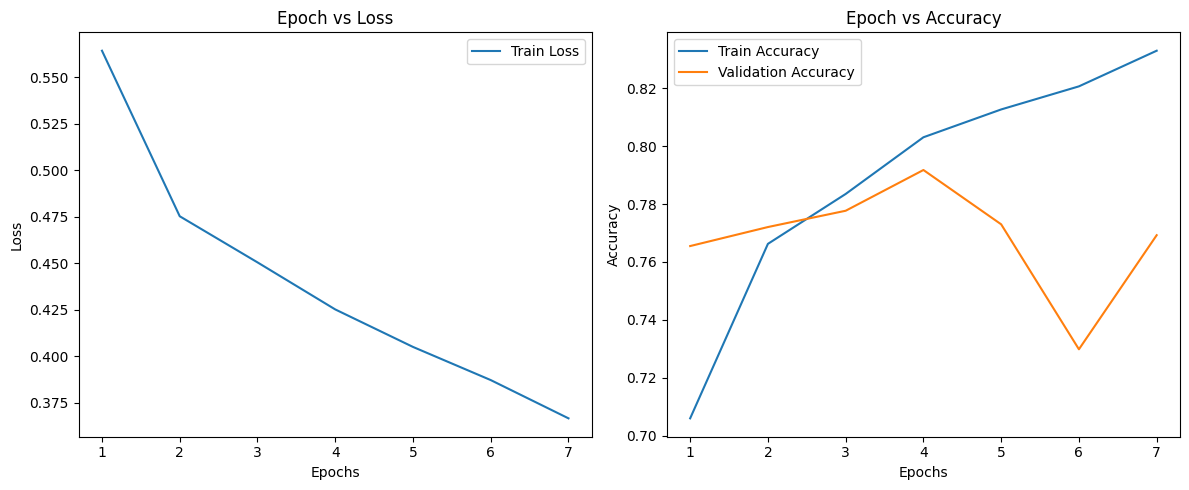

In [64]:
epochs_fw = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_fw, train_losses, train_accuracies, val_accuracies)

In [65]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_OOV_freeze, test_loader)
test_accuracies['RNN (Handle OOV)'] = test_acc
print(f'Test Accuracy (Handle OOV): {test_acc:.4f}')

Test Accuracy (Handle OOV): 0.7655


### 2) Update Word Embeddings

In [66]:
# Call grid search
best_hyperparams_OOV_update = run_grid_search(MaxPoolingRNNModelUpdate, embedding_matrix_spelling_bpe, hidden_dim, output_dim, train_sequences, train_labels,
                                   validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6937, Train Acc: 0.5053, Val Acc: 0.5009
Epoch 2, Train Loss: 0.6923, Train Acc: 0.5158, Val Acc: 0.5141
Epoch 3, Train Loss: 0.6898, Train Acc: 0.5338, Val Acc: 0.5310
Epoch 4, Train Loss: 0.6867, Train Acc: 0.5605, Val Acc: 0.6201
Epoch 5, Train Loss: 0.6837, Train Acc: 0.5819, Val Acc: 0.5131
Epoch 6, Train Loss: 0.6817, Train Acc: 0.5845, Val Acc: 0.6482
Epoch 7, Train Loss: 0.6777, Train Acc: 0.6094, Val Acc: 0.6041
Epoch 8, Train Loss: 0.6744, Train Acc: 0.6184, Val Acc: 0.6632
Epoch 9, Train Loss: 0.6712, Train Acc: 0.6365, Val Acc: 0.6585
Epoch 10, Train Loss: 0.6644, Train Acc: 0.6580, Val Acc: 0.6801
Epoch 11, Train Loss: 0.6593, Train Acc: 0.6720, Val Acc: 0.6923
Epoch 12, Train Loss: 0.6520, Train Acc: 0.6878, Val Acc: 0.6867
Epoch 13, Train Loss: 0.6428, Train Acc: 0.6971, Val Acc: 0.7054
Epoch 14, Train Loss: 0.6320, Train Acc: 0.7035, Val Acc: 0.7008
Epoch 15, Train Loss: 0.6184, Train Acc: 0.703

In [67]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_OOV_update['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [68]:
# Retrain using best hyperparameters
best_model_OOV_update = MaxPoolingRNNModelUpdate(embedding_matrix_spelling_bpe, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_OOV_update['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])
elif best_hyperparams_OOV_update['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])
elif best_hyperparams_OOV_update['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])
elif best_hyperparams_OOV_update['optimizer']=='Adagrad':
    best_optimizer = optim.Adagrad(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])
best_model_OOV_update, train_losses, train_accuracies, val_accuracies = train_model(best_model_OOV_update, train_loader, validation_loader,
                                                                                    best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5586, Train Acc: 0.7050, Val Acc: 0.7148
Epoch 2, Train Loss: 0.4308, Train Acc: 0.7999, Val Acc: 0.7899
Epoch 3, Train Loss: 0.3725, Train Acc: 0.8372, Val Acc: 0.7542
Epoch 4, Train Loss: 0.3288, Train Acc: 0.8577, Val Acc: 0.7955
Epoch 5, Train Loss: 0.2953, Train Acc: 0.8788, Val Acc: 0.7664
Epoch 6, Train Loss: 0.2616, Train Acc: 0.8954, Val Acc: 0.7795
Epoch 7, Train Loss: 0.2318, Train Acc: 0.9089, Val Acc: 0.8021
Epoch 8, Train Loss: 0.2124, Train Acc: 0.9176, Val Acc: 0.7983
Epoch 9, Train Loss: 0.1920, Train Acc: 0.9244, Val Acc: 0.7889
Epoch 10, Train Loss: 0.1711, Train Acc: 0.9366, Val Acc: 0.8002
Early stopping


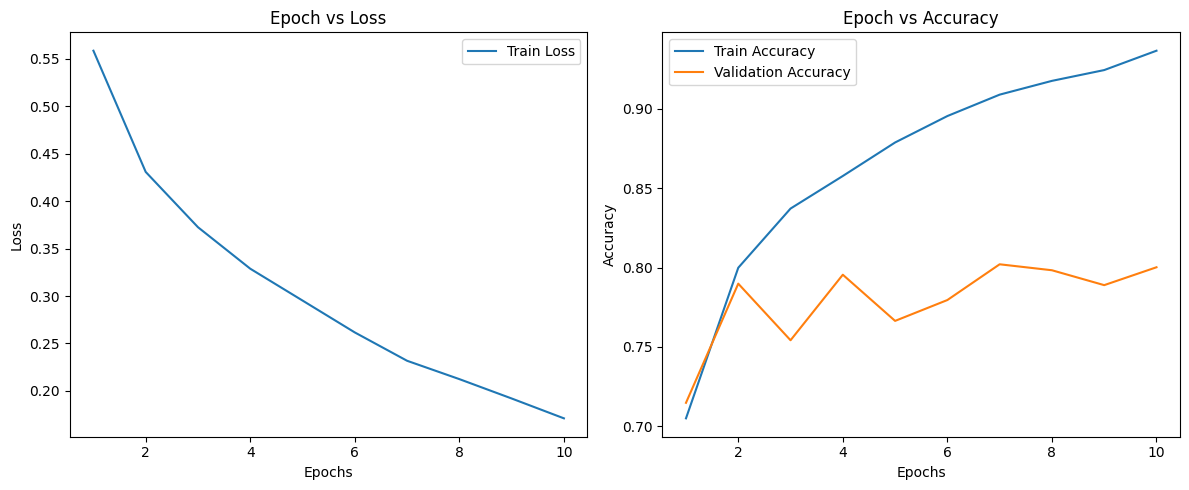

In [69]:
epochs_w = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_w, train_losses, train_accuracies, val_accuracies)

In [70]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_OOV_update, test_loader)
test_accuracies['RNN (Handle OOV with Word Embeddings Update)'] = test_acc
print(f'Test Accuracy (Handle OOV with Word Embeddings Update): {test_acc:.4f}')

Test Accuracy (Handle OOV with Word Embeddings Update): 0.8143


### (c) Report the accuracy scores of biLSTM and biGRU on the test set (Part 3.3).

In [71]:
# Define BiLSTM and BiGRU models
class BiLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Linear(hidden_dim * 2, output_dim).to(device)  # Multiplied by 2 for bidirection
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        lstm_output, _ = self.lstm(embedded)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply max pooling over the output of the LSTM
        max_pooled, _ = torch.max(lstm_output, dim=1)  # Shape: [batch_size, hidden_dim * 2]
        output = self.fc(max_pooled)
        return output

class BiGRUModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(BiGRUModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Linear(hidden_dim * 2, output_dim).to(device)  # Multiplied by 2 for bidirection
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        gru_output, _ = self.gru(embedded)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply max pooling over the output of the GRU
        max_pooled, _ = torch.max(gru_output, dim=1)  # Shape: [batch_size, hidden_dim * 2]
        output = self.fc(max_pooled)
        return output

In [72]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

### 1) biLSTM

In [73]:
# Call grid search
best_hyperparams_biLSTM = run_grid_search(BiLSTMModel, embedding_matrix_spelling_bpe, hidden_dim, output_dim, train_sequences, train_labels,
                                          validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6935, Train Acc: 0.5143, Val Acc: 0.5563
Epoch 2, Train Loss: 0.6919, Train Acc: 0.5327, Val Acc: 0.5197
Epoch 3, Train Loss: 0.6911, Train Acc: 0.5535, Val Acc: 0.5675
Epoch 4, Train Loss: 0.6904, Train Acc: 0.5495, Val Acc: 0.5450
Epoch 5, Train Loss: 0.6897, Train Acc: 0.5599, Val Acc: 0.6323
Epoch 6, Train Loss: 0.6889, Train Acc: 0.5815, Val Acc: 0.6163
Epoch 7, Train Loss: 0.6884, Train Acc: 0.6100, Val Acc: 0.6266
Epoch 8, Train Loss: 0.6872, Train Acc: 0.5667, Val Acc: 0.5394
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.4916, Train Acc: 0.7578, Val Acc: 0.7983
Epoch 2, Train Loss: 0.3075, Train Acc: 0.8628, Val Acc: 0.8058
Epoch 3, Train Loss: 0.1573, Train Acc: 0.9409, Val Acc: 0.7936
Epoch 4, Train Loss: 0.0689, Train Acc: 0.9770, Val Acc: 0.7852
Epoch 5, Train Loss: 0.0291, Train Acc: 0.9906, Val Acc: 0.7927
Early stopping
Training with lr=0.001, batch_s

In [74]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_biLSTM['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [75]:
# Retrain using best hyperparameters
best_model_biLSTM = BiLSTMModel(embedding_matrix_spelling_bpe, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_biLSTM['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])
elif best_hyperparams_biLSTM['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])
elif best_hyperparams_biLSTM['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])
elif best_hyperparams_biLSTM['optimizer']=='Adagrad':
    best_optimizer = optim.Adagrad(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])
best_model_biLSTM, train_losses, train_accuracies, val_accuracies = train_model(best_model_biLSTM, train_loader, validation_loader,
                                                                                best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5015, Train Acc: 0.7502, Val Acc: 0.7129
Epoch 2, Train Loss: 0.3279, Train Acc: 0.8540, Val Acc: 0.8161
Epoch 3, Train Loss: 0.2197, Train Acc: 0.9101, Val Acc: 0.8077
Epoch 4, Train Loss: 0.1408, Train Acc: 0.9450, Val Acc: 0.8030
Epoch 5, Train Loss: 0.0815, Train Acc: 0.9702, Val Acc: 0.7927
Early stopping


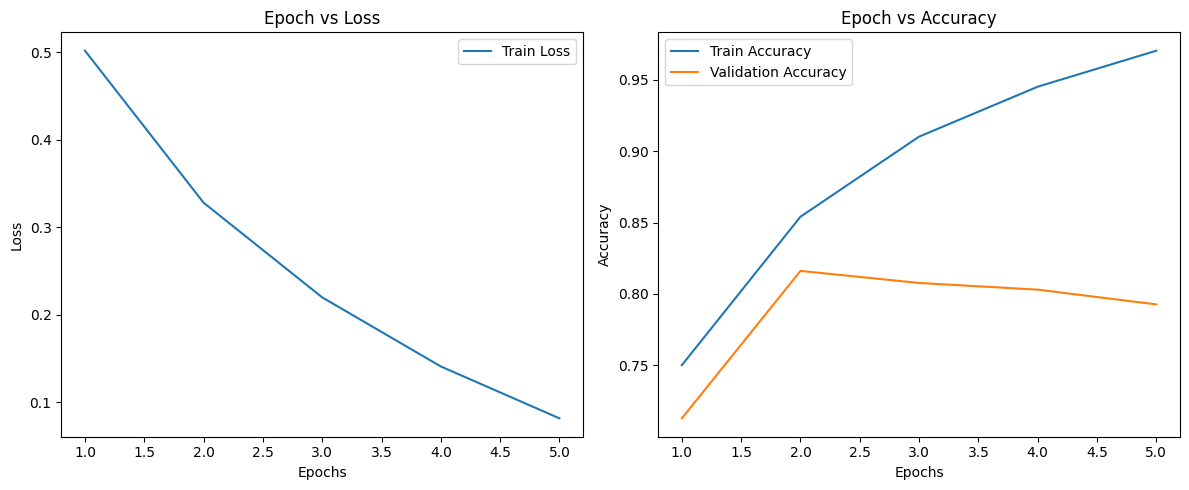

In [76]:
epochs_bi = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_bi, train_losses, train_accuracies, val_accuracies)

In [77]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_biLSTM, test_loader)
test_accuracies['biLSTM'] = test_acc
print(f'Test Accuracy (biLSTM): {test_acc:.4f}')

Test Accuracy (biLSTM): 0.8246


### 2) biGRU

In [78]:
# Call grid search
best_hyperparams_biGRU = run_grid_search(BiGRUModel, embedding_matrix_spelling_bpe, hidden_dim, output_dim, train_sequences, train_labels,
                                         validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6915, Train Acc: 0.5268, Val Acc: 0.5478
Epoch 2, Train Loss: 0.6893, Train Acc: 0.5431, Val Acc: 0.5985
Epoch 3, Train Loss: 0.6869, Train Acc: 0.5652, Val Acc: 0.6351
Epoch 4, Train Loss: 0.6841, Train Acc: 0.5921, Val Acc: 0.6201
Epoch 5, Train Loss: 0.6810, Train Acc: 0.5918, Val Acc: 0.5619
Epoch 6, Train Loss: 0.6790, Train Acc: 0.6040, Val Acc: 0.6689
Epoch 7, Train Loss: 0.6764, Train Acc: 0.6328, Val Acc: 0.6792
Epoch 8, Train Loss: 0.6734, Train Acc: 0.6397, Val Acc: 0.6163
Epoch 9, Train Loss: 0.6711, Train Acc: 0.6468, Val Acc: 0.7064
Epoch 10, Train Loss: 0.6679, Train Acc: 0.6619, Val Acc: 0.6914
Epoch 11, Train Loss: 0.6650, Train Acc: 0.6653, Val Acc: 0.6979
Epoch 12, Train Loss: 0.6606, Train Acc: 0.6757, Val Acc: 0.6970
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.4937, Train Acc: 0.7494, Val Acc: 0.7927
Epoch 2, Train Loss: 0.3103, Train Acc: 0.8

In [79]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_biGRU['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [80]:
# Retrain using best hyperparameters
best_model_biGRU = BiGRUModel(embedding_matrix_spelling_bpe, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_biGRU['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])
elif best_hyperparams_biGRU['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])
elif best_hyperparams_biGRU['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])
elif best_hyperparams_biGRU['optimizer']=='Adagrad':
    best_optimizer = optim.Adagrad(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])
best_model_biGRU, train_losses, train_accuracies, val_accuracies = train_model(best_model_biGRU, train_loader, validation_loader,
                                                                               best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5140, Train Acc: 0.7468, Val Acc: 0.7927
Epoch 2, Train Loss: 0.3292, Train Acc: 0.8585, Val Acc: 0.8030
Epoch 3, Train Loss: 0.2410, Train Acc: 0.9039, Val Acc: 0.8068
Epoch 4, Train Loss: 0.1785, Train Acc: 0.9306, Val Acc: 0.7908
Epoch 5, Train Loss: 0.1227, Train Acc: 0.9569, Val Acc: 0.7908
Epoch 6, Train Loss: 0.0927, Train Acc: 0.9674, Val Acc: 0.7908
Early stopping


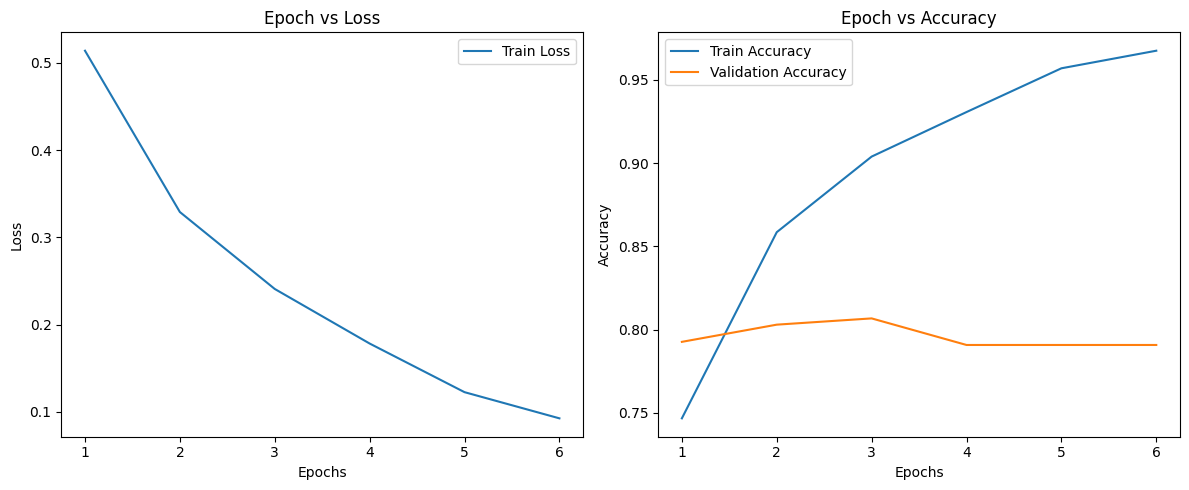

In [81]:
epochs_big = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_big, train_losses, train_accuracies, val_accuracies)

In [82]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_biGRU, test_loader)
test_accuracies['biGRU'] = test_acc
print(f'Test Accuracy (biGRU): {test_acc:.4f}')

Test Accuracy (biGRU): 0.8199


### (d) Report the accuracy scores of CNN on the test set (Part 3.4).

In [83]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, embedding_matrix, output_dim):
        super(CNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)
        self.conv1 = nn.Conv2d(1, 100, (3, embedding_dim)).to(device)  # 1 input channel, 100 output channels
        self.fc = nn.Linear(100, output_dim).to(device)
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x).unsqueeze(1)  # Add channel dimension
        conv_out = self.conv1(embedded).squeeze(3)  # Shape: (batch_size, 100, sequence_length - filter_size + 1)
        conv_out = torch.relu(conv_out)  # Apply ReLU
        pooled = nn.functional.max_pool1d(conv_out, conv_out.size(2)).squeeze(2)  # Max pooling
        output = self.fc(self.dropout(pooled))
        return output

In [84]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

In [85]:
best_val_acc = 0
best_hyperparams_CNN = {}

# Prepare datasets
train_data = TensorDataset(train_sequences.to(device), train_labels.to(device))
validation_data = TensorDataset(validation_sequences.to(device), validation_labels.to(device))

# Grid search
for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            print(f"Training with lr={lr}, batch_size={batch_size}, optimizer={opt}")

            # Set up DataLoader with the current batch size
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

            # Initialize a new model for each set of hyperparameters
            model = CNNModel(embedding_matrix=embedding_matrix_spelling_bpe, output_dim=output_dim)  # Reinitialize model
            model = model.to(device)

            # Choose optimizer
            if opt == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            elif opt == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)
            elif opt == 'Adagrad':
                optimizer = optim.Adagrad(model.parameters(), lr=lr)
            # Train and evaluate the model
            val_acc, _, _, _ = train_and_evaluate_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience)


            # Track the best configuration based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'optimizer': opt}

print(f"Best Validation Accuracy: {best_val_acc}")
print(f"Best Hyperparameters: {best_hyperparams}")

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6966, Train Acc: 0.5067, Val Acc: 0.5356
Epoch 2, Train Loss: 0.6873, Train Acc: 0.5447, Val Acc: 0.6323
Epoch 3, Train Loss: 0.6823, Train Acc: 0.5647, Val Acc: 0.6689
Epoch 4, Train Loss: 0.6739, Train Acc: 0.6015, Val Acc: 0.6689
Epoch 5, Train Loss: 0.6666, Train Acc: 0.6234, Val Acc: 0.6914
Epoch 6, Train Loss: 0.6579, Train Acc: 0.6369, Val Acc: 0.7139
Epoch 7, Train Loss: 0.6472, Train Acc: 0.6632, Val Acc: 0.7251
Epoch 8, Train Loss: 0.6384, Train Acc: 0.6693, Val Acc: 0.7420
Epoch 9, Train Loss: 0.6241, Train Acc: 0.6948, Val Acc: 0.7430
Epoch 10, Train Loss: 0.6128, Train Acc: 0.7018, Val Acc: 0.7420
Epoch 11, Train Loss: 0.6000, Train Acc: 0.7083, Val Acc: 0.7448
Epoch 12, Train Loss: 0.5874, Train Acc: 0.7202, Val Acc: 0.7411
Epoch 13, Train Loss: 0.5747, Train Acc: 0.7264, Val Acc: 0.7411
Epoch 14, Train Loss: 0.5660, Train Acc: 0.7219, Val Acc: 0.7411
Early stopping
Training with lr=0.001, batch_s

In [86]:
best_hyperparams_CNN = best_hyperparams

In [87]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_CNN['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [88]:
# Retrain using best hyperparameters
best_model_CNN = CNNModel(embedding_matrix_spelling_bpe, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_CNN['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])
elif best_hyperparams_CNN['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])
elif best_hyperparams_CNN['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])
elif best_hyperparams_CNN['optimizer']=='Adagrad':
    best_optimizer = optim.Adagrad(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])
best_model_CNN, train_losses, train_accuracies, val_accuracies = train_model(best_model_CNN, train_loader, validation_loader,
                                                                             best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5095, Train Acc: 0.7506, Val Acc: 0.7842
Epoch 2, Train Loss: 0.3243, Train Acc: 0.8666, Val Acc: 0.7786
Epoch 3, Train Loss: 0.2174, Train Acc: 0.9220, Val Acc: 0.7805
Epoch 4, Train Loss: 0.1465, Train Acc: 0.9542, Val Acc: 0.7795
Early stopping


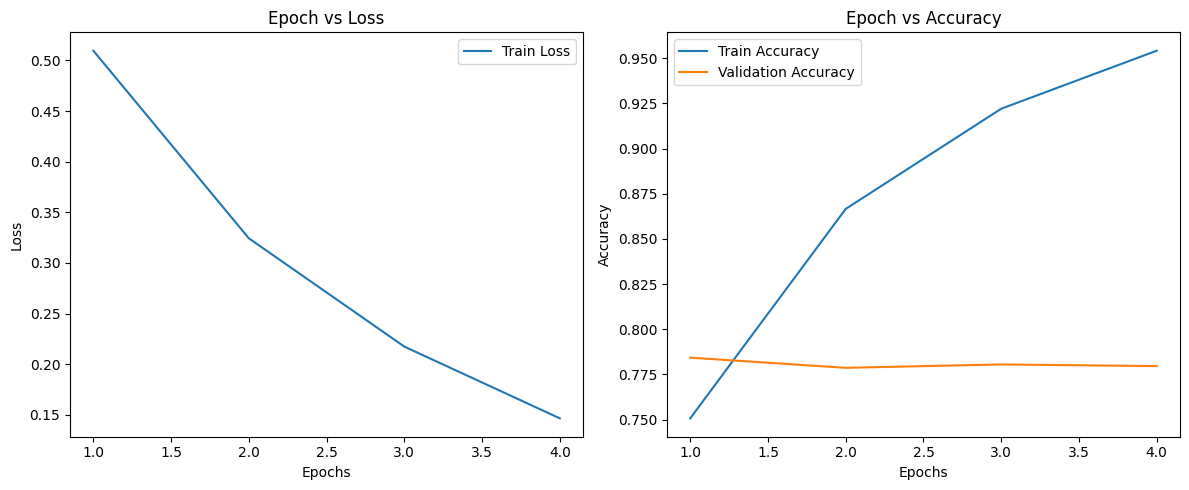

In [89]:
epochs_cnn = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_cnn, train_losses, train_accuracies, val_accuracies)

In [90]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_CNN, test_loader)
test_accuracies['CNN'] = test_acc
print(f'Test Accuracy (CNN): {test_acc:.4f}')

Test Accuracy (CNN): 0.7908


### (e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set using your improved model.

### Ensemble Methods

This setup aggregates the model predictions by averaging the class probabilities across each model, then assigns the final prediction based on the highest average probability. This approach should increase overall stability and potentially improve the test accuracy of your sentiment classification task by leveraging the diverse perspectives of different models.

In [91]:
def ensemble_predict(models, data_loader):
    all_probs = []

    # Collect prediction probabilities from each model
    for model in models:
        model.eval()  # Set to evaluation mode
        model_probs = []
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                model_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
        all_probs.append(np.vstack(model_probs))

    # Average the probabilities across models
    avg_probs = np.mean(all_probs, axis=0)
    final_preds = np.argmax(avg_probs, axis=1)

    return final_preds

In [92]:
def compute_ensemble_accuracy(models, test_loader, test_labels):
    # Get ensemble predictions
    ensemble_preds = ensemble_predict(models, test_loader)

    # Calculate accuracy
    accuracy = np.mean(ensemble_preds == test_labels.cpu().numpy())
    print(f'Test Accuracy (Ensemble): {accuracy:.4f}')

    return accuracy

In [95]:
trained_models = [best_model_biGRU,best_model_biLSTM,best_model_OOV_update,best_model_RNN_update]

# Compute ensemble accuracy on the test set
test_acc = compute_ensemble_accuracy(trained_models, test_loader, test_labels)
test_accuracies['Ensemble'] = test_acc

Test Accuracy (Ensemble): 0.8340


From the test accuracies, we see that when employing **ensemble method with soft voting (probability averaging)** gives us a higher test accuracy compared to the test accuracies of each individual model.

###  (f) Compare the results across different solutions above and describe your observations with possible discussions.

In [96]:
test_accuracies

{'RNN Last Hidden State': 0.7692307692307693,
 'RNN Max Pooling': 0.7870544090056285,
 'RNN Average Pooling': 0.7729831144465291,
 'RNN (Update Word Embeddings)': 0.8133208255159474,
 'RNN (Handle OOV)': 0.7654784240150094,
 'RNN (Handle OOV with Word Embeddings Update)': 0.8142589118198874,
 'biLSTM': 0.8245778611632271,
 'biGRU': 0.8198874296435272,
 'CNN': 0.7908067542213884,
 'Ensemble': 0.8339587242026266}